<img src="https://drive.google.com/uc?export=view&id=1e7ctPi8O3bTQoLZaO9ZZjwGr2r8Z93RS" width="100%">

# Taller 3
---

En este taller se evaluarán las habilidades adquiridas en _embeddings_ a partir del conjunto de datos de Kaggle: [Tweets from El Espectador](https://www.kaggle.com/datasets/jcatumba/tweetsfromelespectador), el cual contiene tweets del periódico colombiano [El Espectador](https://www.elespectador.com/).

En este caso, usted deberá limpiar el conjunto de datos, calcular algunas representaciones, estimar algunas métricas y generar visualizaciones de los datos. Comenzamos importando las librerías necesarias:

In [1]:
#TEST_CELL
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.3 MB/s eta 0:00:00


In [2]:
import re
from typing import Counter
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode
from IPython.display import display
plt.style.use("ggplot")
spacy.cli.download("es_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Comenzamos cargando el conjunto de datos:

In [3]:
#TEST_CELL
df = pd.read_parquet("https://raw.githubusercontent.com/mindlab-unal/mlds4-datasets/main/u3/espectador.parquet")
display(df.head())

,year,text
0,2019,#Feliz2020 Aquí debe quedarse si lo suyo son l...
1,2019,"RT @EspectadorVideo: Una novia caimán, entre l..."
2,2019,Las imágenes de los voraces incendios que acor...
3,2019,Los eventos deportivos a seguir en 2020.\nhttp...
4,2019,"Cantando “muerte a Estados Unidos”, manifestan..."


Este conjunto de datos contiene dos columnas:

- `text`: texto del Tweet.
- `year`: año de publicación.

Este corpus está conformado por `9000` documentos:

In [4]:
#TEST_CELL
display(df.shape[0])

9000

## **1. Preprocesamiento**
---

En este punto deberá preprocesar los documentos de acuerdo al siguiente procedimiento:

1. Convertir en minúsculas.
2. Eliminar acentos.
3. Eliminar todos los caracteres que no sean letras minúsculas.
4. Eliminar espacios duplicados.
5. Filtrar stopwords y palabras de 3 o menos letras.
6. Eliminar caracteres vacíos al inicio y final de cada texto.

Puede usar el siguiente _Pipeline_ de `spacy`:

In [5]:
nlp = spacy.load(
        "es_core_news_sm",
        exclude=[
            "tok2vec",
            "morphologizer",
            "parser",
            "senter",
            "attribute_ruler",
            "lemmatizer",
            "ner"
            ]
        )

Para esto, deberá implementar la función `preprocess` la cual recibirá como entrada un texto crudo y un _Pipeline_ de `spacy` para retornar el texto preprocesado.

**Parámetros**

- `text`: texto crudo.
- `nlp`: _Pipeline_ de `spacy`.

**Retorna**

- `preprocess_text`: texto preprocesado.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

- Recuerde que puede usar `unidecode` para eliminar acentos.
- Debe construir expresiones regulares con `re` para eliminar caracteres especiales.
- El _Pipeline_ de `spacy` debe usarse exclusivamente para eliminar _stopwords_.
</details>

In [64]:
# FUNCIÓN CALIFICADA preprocess:

def preprocess(text, nlp):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    norm_text = unidecode(text).lower()
    pat = re.compile(r"[^a-z ]")
    spaces = re.compile(r"\s{2,}")
    clean_text = re.sub(pat, " ", norm_text)
    preprocess_text = re.sub(spaces, " ", clean_text)
    doc = nlp(preprocess_text.strip())
    stops = list(filter(lambda token: not token.is_stop, doc))
    filtered_tokens = list(filter(
            lambda token:  len(token) > 3,
            stops
        ))
    strings = [token.text for token in filtered_tokens]
    preprocess_text = " ".join(strings)
    return preprocess_text
    ### FIN DEL CÓDIGO ###

In [65]:
#TEST_CELL
text = preprocess(df.text.iloc[0], nlp)
display(text)

'feliz quedarse deportes extremos https usckq https eeqnt'

**Salida esperada**:

En este primer ejemplo debe obtener el primer documento pre-procesado:

```python
❱ display(text)
'feliz quedarse deportes extremos https usckq https eeqnt'
```

In [66]:
#TEST_CELL
text = preprocess(df.text.iloc[1], nlp)
display(text)

'espectadorvideo novia caiman imagenes curiosas deja https lkqoijcuwu https gjyqxbhdib'

**Salida esperada**:

En este primer ejemplo debe obtener el segundo documento pre-procesado:

```python
❱ display(text)
'espectadorvideo novia caiman imagenes curiosas deja https lkqoijcuwu https gjyqxbhdib'
```

## **2. Bolsa de palabras**
---

En este punto deberá extraer una representación de bolsa de palabras basada en conteos. Esta representación debe usar únicamente los 2000 tokens más comunes del corpus.

Para esto deberá implementar la función `bow`, la cual tiene como entrada el corpus preprocesado y deberá retornar un arreglo de `numpy` con los resultados:

**Parámetros**

- `preprocess_corpus`: corpus con los textos preprocesados.

**Retorna**

- `X`: representación de bolsa de palabras.
- `vect`: vectorizador de `sklearn` entrenado.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

- Recuerde filtrar los 2000 términos más frecuentes con el parámetro `max_features`.
- Recuerde convertir el resultado a un arreglo de `numpy` con el método `toarray`.
</details>

In [67]:
# FUNCIÓN CALIFICADA bow:
from sklearn.feature_extraction.text import CountVectorizer

def bow(preprocess_corpus):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    vect = (CountVectorizer(max_features=2000).fit(preprocess_corpus))
    X = vect.transform(preprocess_corpus).toarray()
    return X, vect
    ### FIN DEL CÓDIGO ###

In [68]:
#TEST_CELL
preprocess_text = df.text.apply(preprocess, nlp=nlp)
X, vect = bow(preprocess_text)
display(X.shape)

(9000, 2000)

**Salida esperada**:

En este caso, debería obtener el tamaño del arreglo:

```python
❱ display(X.shape)
(9000, 2000)
```

In [69]:
#TEST_CELL
display(vect.get_feature_names_out()[:10])

array(['abogado', 'aborto', 'abre', 'abrio', 'abuso', 'acaba', 'acabar',
       'academicos', 'acceder', 'acceso'], dtype=object)

**Salida esperada**:

En este caso debería obtener las primeras 10 palabras del vocabulario:

```python
❱ display(vect.get_feature_names_out()[:10])
array(['abogado', 'aborto', 'abre', 'abrio', 'abuso', 'acaba', 'acabar',
       'academicos', 'acceder', 'acceso'], dtype=object)
```

In [70]:
#TEST_CELL
display(X.sum())

62281

**Salida esperada**:

En este caso deberá obtener la cantidad total de términos incluidos en la bolsa de palabras:

```python
❱ display(X.sum())
62281
```

## **3. Términos Más Frecuentes**
---

En este punto deberá extraer los $N$ términos más frecuentes del conjunto de datos a partir de la bolsa de palabras y el vectorizador.

Para esto deberá implementar la función `get_top_n`, la cual tiene como entrada la representación de bolsa de palabras, el vectorizador y el número top de términos, y deberá retornar una lista con los $N$ términos más frecuentes en el corpus.

**Parámetros**

- `X`: representación de bolsa de palabras.
- `vect`: vectorizador entrenado.
- `n`: número de palabras a extraer.

**Retorna**

- `words`: listado de las $N$ palabras más frecuentes.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

- Puede usar la función `sorted` de `Python` para ordenar términos de acuerdo a una condición.
- Puede convertir los datos a un `pd.Series` y usar métodos como `sort_values`.
</details>

In [148]:
# FUNCIÓN CALIFICADA get_top_n:

def get_top_n(X, vect, n):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    freqs = X.sum(axis=0) # Obtenemos la frecuencia de cada palabra
    words_freqs = dict(zip(vect.get_feature_names_out(), freqs)) # Creamos un diccionario con las palabras y sus frecuencias
    words = sorted(words_freqs, key=lambda x: words_freqs[x], reverse=True)[:n]
    return words
    ### FIN DEL CÓDIGO ###

In [149]:
#TEST_CELL
preprocess_text = df.text.apply(preprocess, nlp=nlp)
X, vect = bow(preprocess_text)
words = get_top_n(X, vect, 5)
display(words)

['https', 'lomasleido', 'colombia', 'bogota', 'anos']

**Salida esperada**:

En este caso deberá obtener las 5 palabras más frecuentes del corpus:

```python
❱ display(words)
['https', 'lomasleido', 'colombia', 'bogota', 'anos']
```

In [150]:
#TEST_CELL
words = get_top_n(X, vect, 10)
display(words)

['https',
 'lomasleido',
 'colombia',
 'bogota',
 'anos',
 'eecolombia',
 'deportesee',
 'covid',
 'pais',
 'presidente']

**Salida esperada**:

En este caso deberá obtener las 10 palabras más frecuentes del corpus:

```python
❱ display(words)
['https',
 'lomasleido',
 'colombia',
 'bogota',
 'anos',
 'eecolombia',
 'deportesee',
 'covid',
 'pais',
 'presidente']
```

## **4. Términos Más Frecuentes en un Año Específico**
---

En este punto deberá filtrar los $N$ términos más frecuentes de un año en específico a partir de la representación de bolsa de palabras, el vectorizador y una lista con el año de cada documento.

Para esto deberá implementar la función `get_top_n_year`, la cual tiene como entrada la representación de bolsa de palabras, el vectorizador, el número top de términos, una lista con los años de cada documento y el año a filtrar. Deberá retornar una lista con los $N$ términos más frecuentes en el corpus.

**Parámetros**

- `X`: representación de bolsa de palabras.
- `vect`: vectorizador entrenado.
- `n`: número de palabras a extraer.
- `years`: lista del año de cada documento.
- `year_query`: año sobre el que se debe filtrar.

**Retorna**

- `words`: lista con las palabras más frecuentes por año.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

- Tenga en cuenta que la lista `years` está alineada con la representación de bolsa de palabras `X`, es decir, el año en la posición 5 (`years[5]`) corresponde a la fila 5 de la representación (`X[5]`).
- Puede usar la indexación basada en máscaras de `numpy` para seleccionar los casos correspondientes.
- Puede reutilizar la función `get_top_n`, recuerde que la tarea es muy similar.
</details>

In [151]:
# FUNCIÓN CALIFICADA get_top_n_year:

def get_top_n_year(X, vect, n, years, year_query):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    import numpy as np
    years=np.array(years)==year_query
    freqs = X[years,:].sum(axis=0) # Obtenemos la frecuencia de cada palabra
    words_freqs = dict(zip(vect.get_feature_names_out(), freqs)) # Creamos un diccionario con las palabras y sus frecuencias
    words = sorted(words_freqs, key=lambda x: words_freqs[x], reverse=True)[:n]
    return words
    ### FIN DEL CÓDIGO ###

In [152]:
#TEST_CELL
preprocess_text = df.text.apply(preprocess, nlp=nlp)
X, vect = bow(preprocess_text)
years = df.year.to_list()
words = get_top_n_year(X, vect, 10, years, 2019)
display(words)

['https',
 'lomasleido',
 'colombia',
 'bogota',
 'anos',
 'deportesee',
 'nacional',
 'diciembre',
 'gobierno',
 'presidente']

**Salida esperada**:

En este caso deberá obtener las 10 palabras más frecuentes del corpus en el año 2019:

```python
❱ display(words)
['https',
 'lomasleido',
 'colombia',
 'bogota',
 'anos',
 'deportesee',
 'nacional',
 'diciembre',
 'gobierno',
 'presidente']
```

In [153]:
#TEST_CELL
preprocess_text = df.text.apply(preprocess, nlp=nlp)
X, vect = bow(preprocess_text)
years = df.year.to_list()
words = get_top_n_year(X, vect, 10, years, 2020)
display(words)

['https',
 'eecolombia',
 'colombia',
 'anos',
 'bogota',
 'lomasleido',
 'diciembre',
 'deportesee',
 'covid',
 'pais']

**Salida esperada**:

En este caso deberá obtener las 10 palabras más frecuentes del corpus en el año 2020:

```python
❱ display(words)
['https',
 'eecolombia',
 'colombia',
 'anos',
 'bogota',
 'lomasleido',
 'diciembre',
 'deportesee',
 'covid',
 'pais']
```

## **5. Nube de Palabras**
---

En este punto deberá generar una nube de palabras a partir de una representación de bolsa de palabras con un fondo de color blanco.

Para ello, deberá implementar la función `get_wordcloud`, la cual tiene como entrada una representación de bolsa de palabras y un vectorizador y debe generar un objeto de tipo `WordCloud`.

**Parámetros**

- `X`: representación de bolsa de palabras.
- `vect`: vectorizador de `sklearn`.

**Retorna**

- `wc`: nube de palabras.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

- Recuerde que puede usar el parámetro `background_color` para especificar el color del fondo de la imagen.
- El método `generate_from_frequencies` permite generar la nube de palabras a partir de un diccionario donde las claves son las palabras y los valores son los conteos.
</details>

In [143]:
# FUNCIÓN CALIFICADA get_wordcloud:
from wordcloud import WordCloud

def get_wordcloud(X, vect):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    import numpy as np
    counts = np.array(X.sum(axis=0)).flatten()
    counts_dict = {word: count for word, count in zip(vect.get_feature_names_out(), counts)}
    wc = (WordCloud(background_color='#FFFFFF').generate_from_frequencies(counts_dict))
    return wc
    ### FIN DEL CÓDIGO ###

(-0.5, 399.5, 199.5, -0.5)

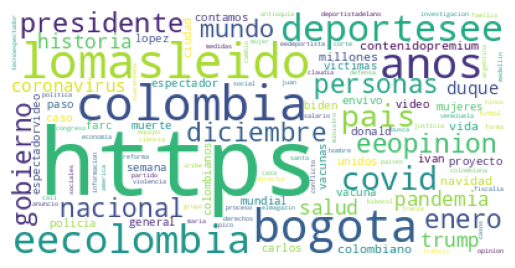

In [144]:
#TEST_CELL
preprocess_text = df.text.apply(preprocess, nlp=nlp)
X, vect = bow(preprocess_text)
wc = get_wordcloud(X, vect)
fig, ax = plt.subplots()
ax.imshow(wc)
ax.axis("off")

**Salida esperada**:

En este caso deberá obtener una imagen similar a la siguiente:

<img src="https://drive.google.com/uc?export=view&id=1MJg-wZhiupR_FAtV8Kz5jZAbhLE1bGNU" width="80%">

**Nota**: el orden de las palabras puede variar un poco, pero el resultado debería ser equivalente.

## **6. Nube de Palabras Por Año**
---

En este punto deberá generar una nube de palabras a partir de una representación de bolsa de palabras para un año específico con un fondo de color blanco.

Para ello, deberá implementar la función `get_wordcloud_year`, la cual tiene como entrada una representación de bolsa de palabras, un vectorizador, una lista de años y un año específico y debe generar un objeto de tipo `WordCloud`.

**Parámetros**

- `X`: representación de bolsa de palabras.
- `vect`: vectorizador de `sklearn`.
- `years`: lista de años por cada documento.
- `year_query`: año a filtrar.

**Retorna**

- `wc`: nube de palabras.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

- Puede reutilizar la función `get_wordcloud`, ya que las tareas son bastante similares.
- Debe filtrar las filas de la representación de bolsa de palabras de la misma forma en la que realizó el punto 4.
</details>

In [146]:
# FUNCIÓN CALIFICADA get_wordcloud:
from wordcloud import WordCloud

def get_wordcloud_year(X, vect, years, year):
    ### ESCRIBA SU CÓDIGO AQUÍ ###
    import numpy as np
    years=np.array(years)==year
    counts = np.array(X[years,:].sum(axis=0)).flatten()
    counts_dict = {word: count for word, count in zip(vect.get_feature_names_out(), counts)}
    wc = (WordCloud(background_color='#FFFFFF').generate_from_frequencies(counts_dict))
    return wc
    ### FIN DEL CÓDIGO ###

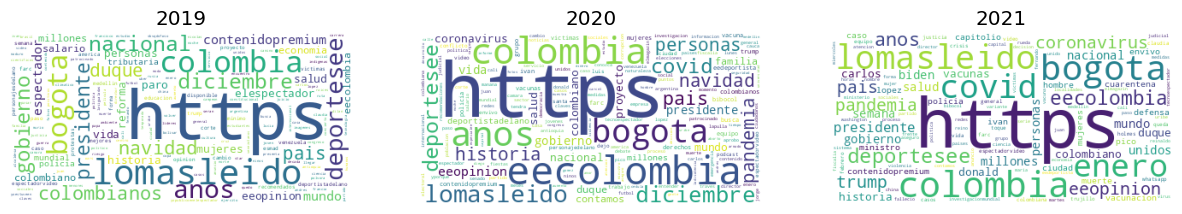

In [147]:
#TEST_CELL
preprocess_text = df.text.apply(preprocess, nlp=nlp)
X, vect = bow(preprocess_text)
years = df.year.to_list()
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
cats = [2019, 2020, 2021]
for i, cat in enumerate(cats):
    ax = axes[i]
    wc = get_wordcloud_year(X, vect, years, cat)
    ax.imshow(wc)
    ax.set_title(cat)
    ax.axis("off")

**Salida esperada**

La celda anterior debería generar una imagen similar a la siguiente:

<img src="https://drive.google.com/uc?export=view&id=1bs1QdYriI7drISHJ5OlATKHxdiFyjWro" width="100%">

## Créditos
---

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*